# <center>Time series forecasting tutorial</center>
---

In [1]:
# Increase notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Link to the tutorial:

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

## Libraries

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime
from statsmodels.tsa.stattools import adfuller # for Dickey-Fuller stationarity test
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

## What makes time series special?

Why is it different from regression?

- It is **time dependent**, so the assumption that observations are independent made in regression does not hold here.
- Along with a general trend, time series data typically contain **seasonality**.

## Data

In [3]:
# Date parser
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m")

In [4]:
df = pd.read_csv("AirPassengers.csv", parse_dates=["Month"], index_col="Month", date_parser=dateparse)

In [5]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [6]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [7]:
df.describe(include="all")

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [8]:
df.dtypes

#Passengers    int64
dtype: object

In [9]:
# Convert the dataframe to a series object. This will make it easier to slice and select the data.
ts = df.squeeze()

In [10]:
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

## Slicing and selecting

In [11]:
# Select the 3rd item in the series (starts at 0)
ts[2]

132

In [12]:
# Select by a specific date
ts["1949-03-01"]

132

In [13]:
# Same as above but using datetime instead of a string
ts[datetime(1949, 3, 1)]

132

In [14]:
# Select all items in year 1949
ts["1949"]

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

In [15]:
# Date ranges 1
ts[:"1949-05-01"] # All dates up to AND INCLUDING the last date (note difference to numerical index slicing)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [16]:
# Date ranges 2
ts["1949-02":"1949-05"] # Using a from and to date range

Month
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

## E.D.A.

### Stationarity of time series

Most time series models work on the assumption that the TS is stationary. Theories related to stationary TS are more mature and easier to implement that for non-stationary TS.

A time series is said to be stationary if it has the following properties:

- constant mean
- constant variance
- an autocovariance that does not depend on time

The following plots illustrate each of these points:

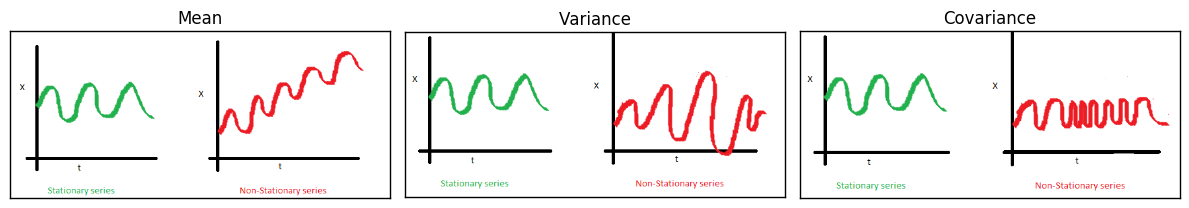

In [17]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 3, 1, frameon=True)
ax1.imshow(plt.imread("Mean_stationary.png"))
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Mean")
ax2 = fig.add_subplot(1, 3, 2, frameon=True)
ax2.imshow(plt.imread("Var_stationary.png"))
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Variance")
ax3 = fig.add_subplot(1, 3, 3, frameon=True)
ax3.imshow(plt.imread("Cov_stationary.png"))
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title("Covariance")

plt.tight_layout()

**Mean:**
In the right-hand chart, the mean is increasing over time.

**Variance:**
In the right-hand chart, the magnitude of the variance is increasing, then decreasing as time passes.

**Covariance:**
In the right-hand chart, the frequency of the variance is time-dependent.

### Airline Passenger raw data

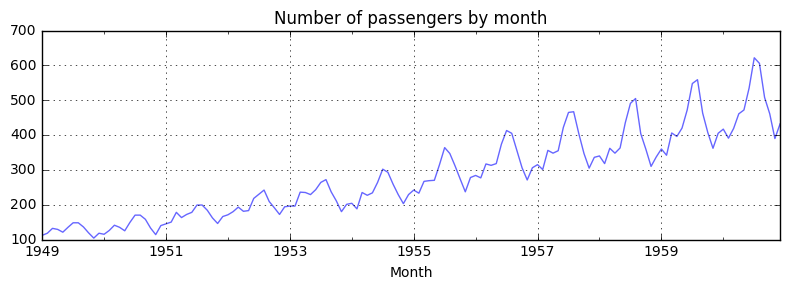

In [18]:
ax = ts.plot(figsize=(8, 3), alpha=0.6, legend=False, title="Number of passengers by month") # Note plotting direct from a Pandas Series
ax.grid(True)
# ax.set_frame_on(False)
plt.tight_layout()

### Stationarity test

Visually we can see our dataset is not stationary. The mean is increasing over time. The variance also seems to be increasing over time. Covariance appears to be constant.

Lets plot the rolling mean and rolling variance (standard deviation, so in same unit as mean) to see this more clearly.

We'll also run the Dickey-Fuller test to determine analytically whether the data is stationary or not.

In [19]:
# Function to plot rolling means and run Dickey-Fuller stationarity test
def test_stationarity(ts):
    
    # Calculate rolling series
    rolmn = pd.rolling_mean(ts, window=12) # rolling mean
    rolstd = pd.rolling_std(ts, window=12) # rolling standard deviation
    
    # Plot rolling statistics
    fig, ax = plt.subplots(figsize=(8, 3))
    orig = ax.plot(ts, color="blue", label="Original", alpha=0.6)
    mean = ax.plot(rolmn, color="red", label="Rolling Mean", alpha=0.6)
    std = ax.plot(rolstd, color="black", label="Rolling Std", alpha=0.6)
    ax.legend(loc="best", fontsize=8)
    ax.set_title("Rolling Mean and Standard Deviation")
    ax.set_xlim(min(df.index))
    ax.grid()
    plt.tight_layout()
    plt.show() # Force chart to render before the test results
    
    # Dickey-Fuller stationarity test
    print("Results of Dickey-Fuller test:")
    dftest = adfuller(ts, autolag="AIC")
    df_output = pd.Series(dftest[0:4], index=["Test statistic", "p-value", "#Lags used", "Number of observations used"])
    for key, value in dftest[4].items():
        df_output["Critical value (%s)" % key] = value
    print(df_output)

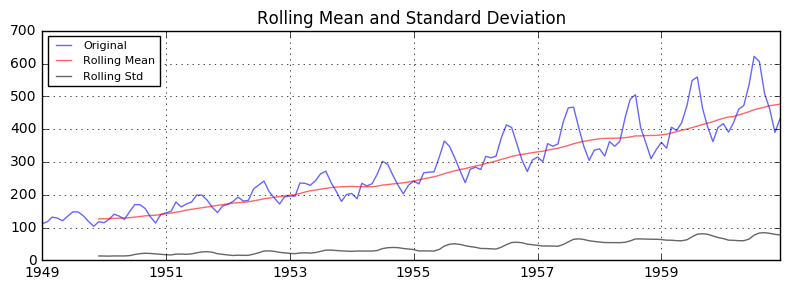

Results of Dickey-Fuller test:
Test statistic                   0.815369
p-value                          0.991880
#Lags used                      13.000000
Number of observations used    130.000000
Critical value (10%)            -2.578770
Critical value (5%)             -2.884042
Critical value (1%)             -3.481682
dtype: float64


In [20]:
test_stationarity(ts)

### Interpreting the Dickey-Fuller test results

- H0: TS is non-stationary.
- H1: TS is stationary.

If test statistic < critical value then reject H0. (Signed values should be compared, not absolute values).

We got a Test statistic of 0.815 which is significantly (see p-value) highter than the Critical values, so we cannot reject H0. Hence, our dataset is non-stationary.

We need to make the dataset stationary in order to construct a time series forecast. Although its practically impossible to make a dataset perfectly stationary we'll try to get it as close as possible.

### Modeling approach

- Make the dataset stationary by removing:
    - Trend
    - Seasonality
    
- Forecast using the stationary dataset.

- Convert the forecast back to original scale by adding back the trend and seasonality estimates.

### Trend - estimating and eliminating

A common starting point for eliminating trend is to apply a transformation.

In our data we can clearly observe an upward trend. There are several possible techniques that will penalize larger values more than small values, including:
- log transformation
- square root
- cube root
- etc.

Lets apply a log transformation to our data for simplicity's sake:

In [21]:
ts_log = np.log(ts)

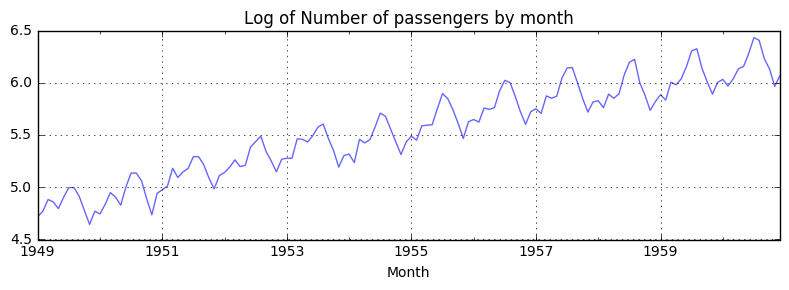

In [22]:
ax = ts_log.plot(figsize=(8, 3), alpha=0.6, legend=False, title="Log of Number of passengers by month") # Note plotting direct from a Pandas Series
ax.grid(True)
# ax.set_frame_on(False)
plt.tight_layout()

Since our data is relatively simple and noise-free, it is straighforward to see the upward trend in the data. In other cases it may not be so easy.

What we need is a way of estimating (or modeling) this trend so that we can then remove it from the series.

There are various techniques for modeling the trend, including
- Aggregation (taking an average over a period of time, e.g. monthly or weekly wages)
- Smoothing (taking a rolling average)
- Polynomial fitting (fitting a regression model)

The best technique will vary by use case. Lets start here by trying smoothing.

Our dataset appears to contain seasonality, cycling approximately every 12 months. So we will use a window of 12 months to create a 1 year rolling average.

In [23]:
# Apply smoothing (simplenmoving average)
moving_avg = pd.rolling_mean(ts_log, 12)

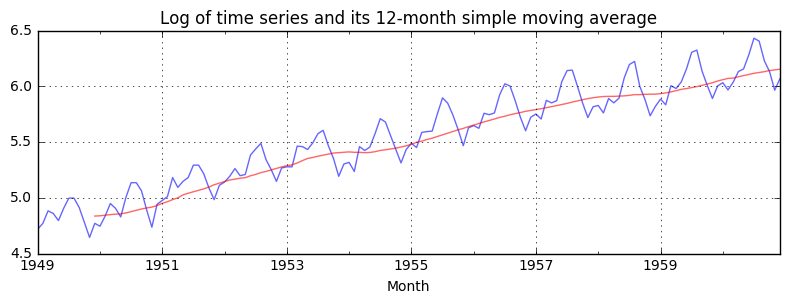

In [24]:
# Plot log of time series and its 12-month simple moving average
fig = plt.figure(figsize=(8, 3))
ax1 = ts_log.plot(alpha=0.6, color="blue")
ax2 = moving_avg.plot(alpha=0.6, color="red")
plt.grid(True)
# ax.set_frame_on(False)
plt.tight_layout()
plt.title("Log of time series and its 12-month simple moving average")

Note that since we are creating a 12 month rolling mean, the first 11 points are missing:

In [25]:
moving_avg.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01    4.836178
Name: #Passengers, dtype: float64

Now we subtract the rolling average from the original log transform to remove the trend. We also need to drop the NA values. Then we'll plot the result to check the trend has been removed.

In [26]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)

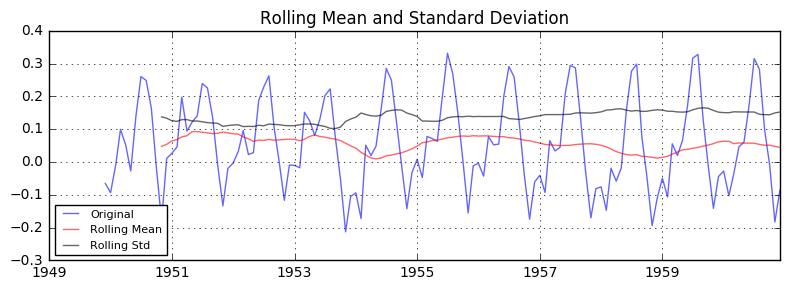

Results of Dickey-Fuller test:
Test statistic                  -3.162908
p-value                          0.022235
#Lags used                      13.000000
Number of observations used    119.000000
Critical value (10%)            -2.579896
Critical value (5%)             -2.886151
Critical value (1%)             -3.486535
dtype: float64


In [27]:
# Run Dickey-Fuller test on resulting series
test_stationarity(ts_log_moving_avg_diff)

This is a better series. Although there are some fluctuations in rolling mean and variation there is no clear trend. Further, the test statistic is below the Critical 5% value, so we can reject H0 and say with 95% confidence that this series is stationary.

A drawback to the simple moving average approach is that the time window has to be strictly defined. In this particular case its fine as we can take the 12 month average.

But in more complex cases (e.g. stock price prediction) the data may not be so friendly. In this case we can take a weighted moving average instead, where more recent periods are given higher weights. There are many techniques for assigning the weights, but the most popular is the **exponential moving average**, where weights are assigned to each previous value with decay factor. A further advantage of this technique over the simple moving average is that all values are assigned a weight, so we don't have the missing value problem we had above.

In [28]:
# Calculate Exponential Weighted Average (EWA)
# NB: half-life gives the number of periods it takes for the weighting to reduce to half of the weight for most recent period.
expweighted_avg = pd.ewma(ts_log, halflife=12)

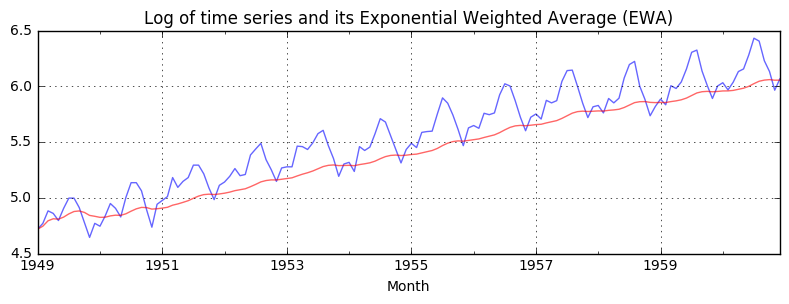

In [29]:
# Plot log of time series and its Exponential Weighted Average (EWA)
fig = plt.figure(figsize=(8, 3))
ax1 = ts_log.plot(alpha=0.6, color="blue")
ax2 = expweighted_avg.plot(alpha=0.6, color="red")
plt.grid(True)
# ax.set_frame_on(False)
plt.tight_layout()
plt.title("Log of time series and its Exponential Weighted Average (EWA)")

Now, let's remove the EWA from the series and check for stationarity:

In [30]:
# Subtract EWA from series
ts_log_ewma_diff = ts_log - expweighted_avg

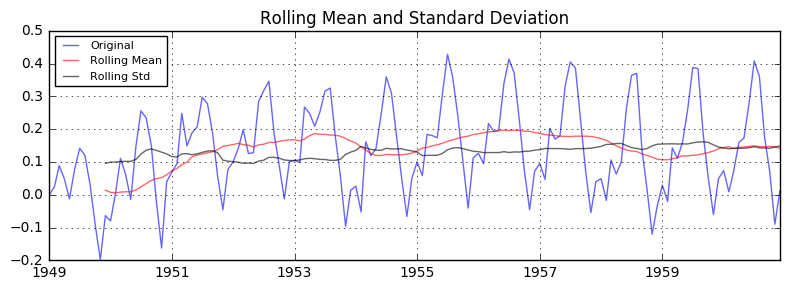

Results of Dickey-Fuller test:
Test statistic                  -3.601262
p-value                          0.005737
#Lags used                      13.000000
Number of observations used    130.000000
Critical value (10%)            -2.578770
Critical value (5%)             -2.884042
Critical value (1%)             -3.481682
dtype: float64


In [31]:
# Run Dickey-Fuller test on resultant series
test_stationarity(ts_log_ewma_diff)

The resultant rolling mean and rolling standard deviation have less variation using the EWA than with the simple moving average. Further, the Dickey-Fuller test statistic of -3.6 is below the 1% critical value of -3.48, therefore we can be >99% confident that this adjusted series is now stationary.

Also, as all values receive a weight when calcuating EWA, we don't have the missing value issue we encountered earlier. Note, however, that the initial values for EWA should be taken with caution, since at the start of the series the EWA has to be initialized from some value (either the current value or the simple weighted average of some window of past values), so this is initial EWA is an estimate.

### Eliminating trend and seasonality

The trend elimination techniques described above don't work in all scenarios, in particular those with high seasonality.

Let's explore 2 techniques for eliminating both trend and seasonality:

- **Differencing**
- **Decomposition**

#### Differencing

Simply take the difference between the current value and a previous value (with some lag). A first order difference can be easily calculated with Pandas as follows:

In [32]:
# Calculate difference of log number of passengers
# NB: The defaulf of the shift function is a lag of 1 period.
ts_log_diff = ts_log - ts_log.shift()

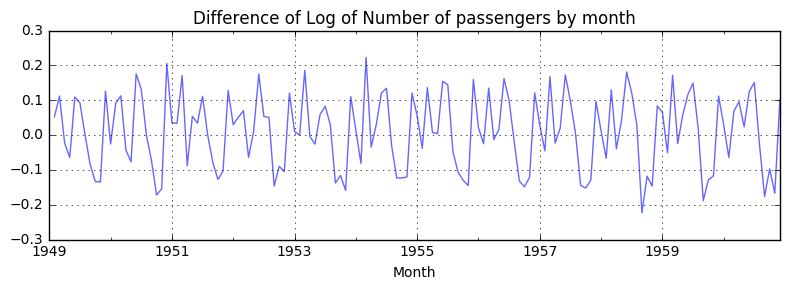

In [33]:
ax = ts_log_diff.plot(figsize=(8, 3), alpha=0.6, legend=False, title="Difference of Log of Number of passengers by month")
ax.grid(True)
# ax.set_frame_on(False)
plt.tight_layout()

In [34]:
# NB: Because we are calculating the difference between a period and the previous period
# we get NaN for the first period in series. This needs to be dropped - see below.
ts_log_diff.head()

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
Name: #Passengers, dtype: float64

This appears to have reduced trend significantly. Lets verify that:

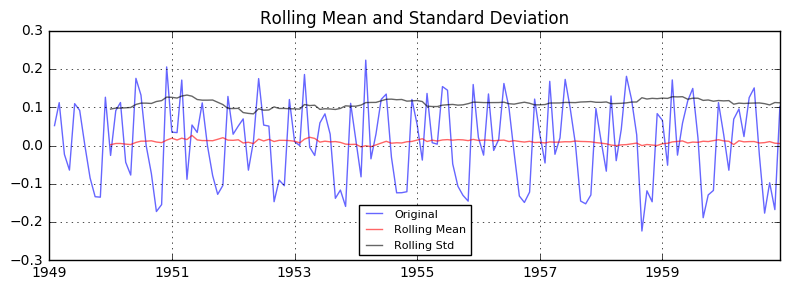

Results of Dickey-Fuller test:
Test statistic                  -2.717131
p-value                          0.071121
#Lags used                      14.000000
Number of observations used    128.000000
Critical value (10%)            -2.578960
Critical value (5%)             -2.884398
Critical value (1%)             -3.482501
dtype: float64


In [35]:
# Run Dickey-Fuller test on resultant series
ts_log_diff.dropna(inplace=True) # The first period is missing so needs to be dropped
test_stationarity(ts_log_diff)

We can see in the above plot that trend and changes in variange are very small over time. Also, the Dickey-Fuller test returns a test statistic of -2.72, which is less than the 10% critical value; so we can say that with the 90% confidence the series is stationary.

In certain scenarios, a second or even third order difference may be appropriate. Lets try that with our dataset:

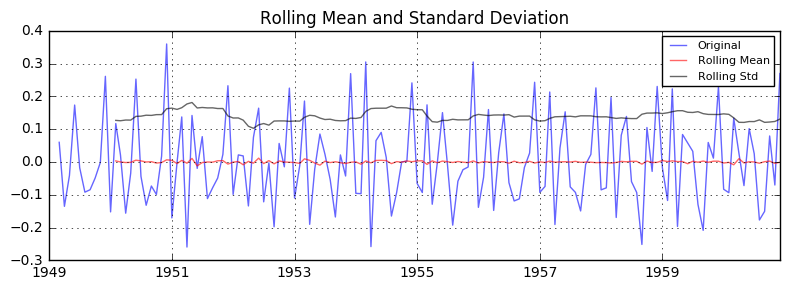

Results of Dickey-Fuller test:
Test statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags used                     1.300000e+01
Number of observations used    1.280000e+02
Critical value (10%)          -2.578960e+00
Critical value (5%)           -2.884398e+00
Critical value (1%)           -3.482501e+00
dtype: float64


In [36]:
# Try 2nd order differencing
ts_log_diff2 = ts_log_diff - ts_log_diff.shift()
ts_log_diff2.dropna(inplace=True)
test_stationarity(ts_log_diff2)

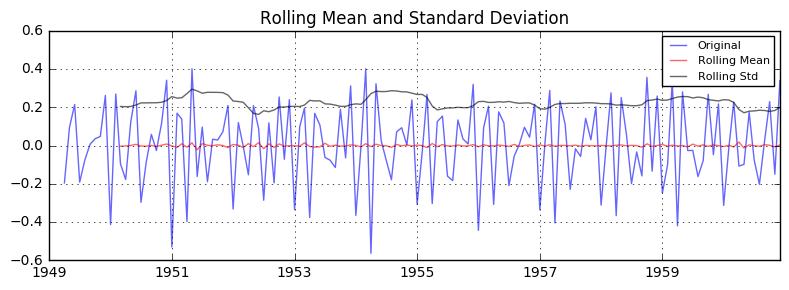

Results of Dickey-Fuller test:
Test statistic                -9.824011e+00
p-value                        5.246133e-17
#Lags used                     1.400000e+01
Number of observations used    1.260000e+02
Critical value (10%)          -2.579156e+00
Critical value (5%)           -2.884766e+00
Critical value (1%)           -3.483346e+00
dtype: float64


In [37]:
# Try 3rd order differencing
ts_log_diff3 = ts_log_diff2 - ts_log_diff2.shift()
ts_log_diff3.dropna(inplace=True)
test_stationarity(ts_log_diff3)

#### Decomposing

In this approach, trend and seasonality are modeled separately and the remaining part of series is returned.

In [38]:
decomposition = seasonal_decompose(ts_log)

In [39]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

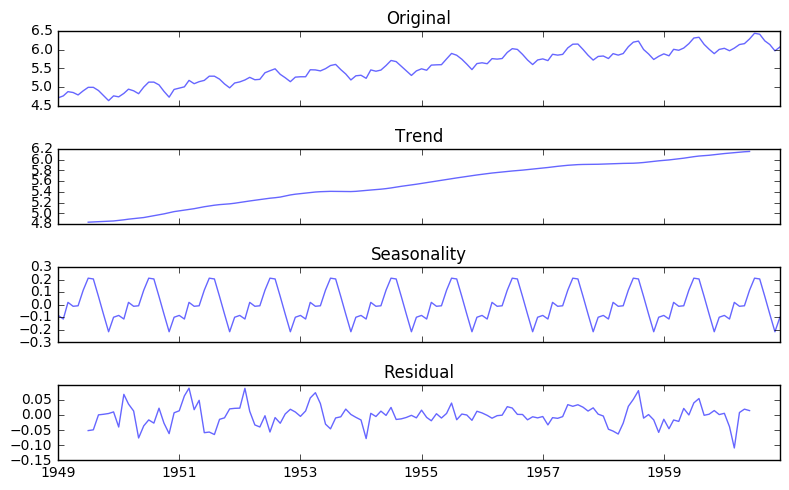

In [40]:
fig, axarr = plt.subplots(4, sharex=True, figsize=(8, 5))
axarr[0].plot(ts_log, alpha=0.6)
axarr[0].set_title("Original")
axarr[1].plot(trend, alpha=0.6)
axarr[1].set_title("Trend")
axarr[2].plot(seasonal, alpha=0.6)
axarr[2].set_title("Seasonality")
axarr[3].plot(residual, alpha=0.6)
axarr[3].set_title("Residual")
fig.tight_layout()

Now we've extracted the trend and seasonality from the original series, we can check the stationarity of the residuals:

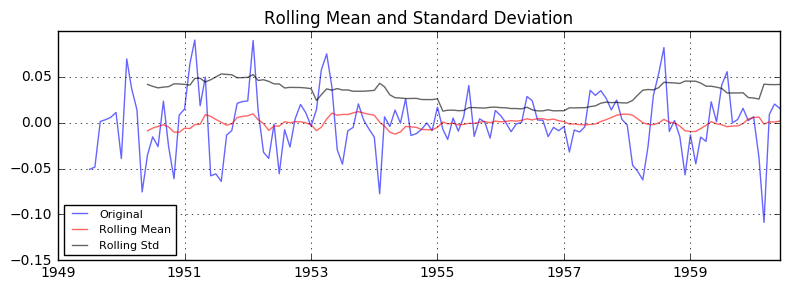

Results of Dickey-Fuller test:
Test statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags used                     9.000000e+00
Number of observations used    1.220000e+02
Critical value (10%)          -2.579569e+00
Critical value (5%)           -2.885538e+00
Critical value (1%)           -3.485122e+00
dtype: float64


In [41]:
residual.dropna(inplace=True)
test_stationarity(residual)

The Dickey-Fuller test shows that the residual series is very close to stationary as the test statistic of -6.33 is way below the critical 1% value of -3.49. So we can say that with greater than 99% confidence that the series is stationary.

There are more advance decomposition techniques, which can generate better results.

Converting the residuals back into the original values for future data is not very intuitive in this case.

### Forecasting a time series

OK, let's now put this all together and attempt to make a forecast model for the time series.

First, we have have to make the dataset stationary, because time series forecasting does not work on non-stationary series. We looked at several methods to do this above, but we will use differencing here because 1) its a very common technique and 2) its relatively easy to add noise and seasonality back to the predicted residuals.

The result of performing the trend and seasonality estimation techniques will indicate one of 2 situations:

    1) We have a strictly stationary series (no movement in mean or variation over time).
    2) We have a non-staionary time series. In this case we need to use a statistical model, like ARIMA, to make predictions.

#### ARIMA concepts

Auto-Regressive Integrated Moving-Average.

The ARIMA model for a stationary time-series is nothing more than a linear equation (like a linear regression). The predictors depend on the values p, d, and q of the ARIMA model:

- p = the number of Auto-Regressive terms. This is the number of lags of the dependent variable. E.g. if p=5, the predictors for x(t) are x(t-1)...x(t-5).
- q = the number of Moving-Average terms. This is the number of lagged forecast errors. E.g. if q=5, the predictors for x(t) are e(t-1)...e(t-5) where e(i) is the difference between the moving average at the i-th instant and the actual value.
- d